# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

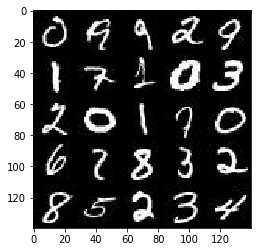

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

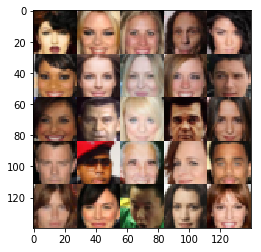

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return real_input, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.05):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28 x 28 x channels
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14 x 14 x 64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7 x 7 x 128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4 x 4 x 256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits) 

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.05):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    inf = not is_train
    with tf.variable_scope('generator', reuse=inf):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7 x 7 x 512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7 x 7 x 256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14 x 14 x 128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28 x 28 x out_channel_dim now
        
        out = tf.tanh(logits)    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    input_real, input_z, learn_rate = model_inputs(*data_shape[1:4], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z,\
                                                   learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, \
                                                  learn_rate: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/5... Batch 10... Discriminator Loss: 1.1272... Generator Loss: 1.7953
Epoch 1/5... Batch 20... Discriminator Loss: 2.2457... Generator Loss: 0.2407
Epoch 1/5... Batch 30... Discriminator Loss: 1.0112... Generator Loss: 3.1804
Epoch 1/5... Batch 40... Discriminator Loss: 1.6379... Generator Loss: 3.8157
Epoch 1/5... Batch 50... Discriminator Loss: 3.6637... Generator Loss: 6.7485
Epoch 1/5... Batch 60... Discriminator Loss: 0.9268... Generator Loss: 2.2689
Epoch 1/5... Batch 70... Discriminator Loss: 1.1572... Generator Loss: 0.7120
Epoch 1/5... Batch 80... Discriminator Loss: 1.3076... Generator Loss: 4.3680
Epoch 1/5... Batch 90... Discriminator Loss: 0.7189... Generator Loss: 2.5308
Epoch 1/5... Batch 100... Discriminator Loss: 0.6654... Generator Loss: 1.5056


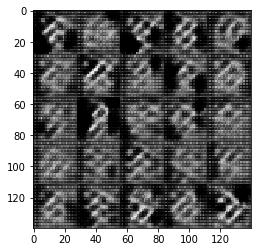

Epoch 1/5... Batch 110... Discriminator Loss: 0.5438... Generator Loss: 2.7644
Epoch 1/5... Batch 120... Discriminator Loss: 0.4903... Generator Loss: 3.4290
Epoch 1/5... Batch 130... Discriminator Loss: 0.4422... Generator Loss: 2.6039
Epoch 1/5... Batch 140... Discriminator Loss: 0.4127... Generator Loss: 3.0422
Epoch 1/5... Batch 150... Discriminator Loss: 0.4099... Generator Loss: 7.6743
Epoch 1/5... Batch 160... Discriminator Loss: 0.3558... Generator Loss: 4.4298
Epoch 1/5... Batch 170... Discriminator Loss: 1.0124... Generator Loss: 6.3173
Epoch 1/5... Batch 180... Discriminator Loss: 0.7625... Generator Loss: 1.3291
Epoch 1/5... Batch 190... Discriminator Loss: 0.4636... Generator Loss: 2.7700
Epoch 1/5... Batch 200... Discriminator Loss: 0.3716... Generator Loss: 3.8233


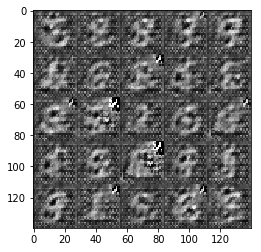

Epoch 1/5... Batch 210... Discriminator Loss: 0.3685... Generator Loss: 4.7768
Epoch 1/5... Batch 220... Discriminator Loss: 0.3648... Generator Loss: 4.9663
Epoch 1/5... Batch 230... Discriminator Loss: 2.3347... Generator Loss: 0.5307
Epoch 2/5... Batch 10... Discriminator Loss: 1.1584... Generator Loss: 2.3959
Epoch 2/5... Batch 20... Discriminator Loss: 0.7254... Generator Loss: 2.5977
Epoch 2/5... Batch 30... Discriminator Loss: 0.6986... Generator Loss: 1.3235
Epoch 2/5... Batch 40... Discriminator Loss: 0.7554... Generator Loss: 1.6164
Epoch 2/5... Batch 50... Discriminator Loss: 1.0828... Generator Loss: 0.8047
Epoch 2/5... Batch 60... Discriminator Loss: 0.7290... Generator Loss: 3.9061
Epoch 2/5... Batch 70... Discriminator Loss: 1.1588... Generator Loss: 5.0132
Epoch 2/5... Batch 80... Discriminator Loss: 0.9123... Generator Loss: 0.9889
Epoch 2/5... Batch 90... Discriminator Loss: 0.6313... Generator Loss: 2.2617
Epoch 2/5... Batch 100... Discriminator Loss: 3.3833... Gener

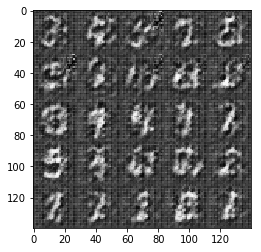

Epoch 2/5... Batch 110... Discriminator Loss: 0.7397... Generator Loss: 1.3180
Epoch 2/5... Batch 120... Discriminator Loss: 0.5629... Generator Loss: 1.9769
Epoch 2/5... Batch 130... Discriminator Loss: 0.6743... Generator Loss: 1.5107
Epoch 2/5... Batch 140... Discriminator Loss: 0.9190... Generator Loss: 1.3931
Epoch 2/5... Batch 150... Discriminator Loss: 0.8343... Generator Loss: 1.3742
Epoch 2/5... Batch 160... Discriminator Loss: 2.5854... Generator Loss: 0.2560
Epoch 2/5... Batch 170... Discriminator Loss: 0.8217... Generator Loss: 1.2053
Epoch 2/5... Batch 180... Discriminator Loss: 0.9077... Generator Loss: 5.6074
Epoch 2/5... Batch 190... Discriminator Loss: 0.8783... Generator Loss: 1.6481
Epoch 2/5... Batch 200... Discriminator Loss: 0.6003... Generator Loss: 2.0581


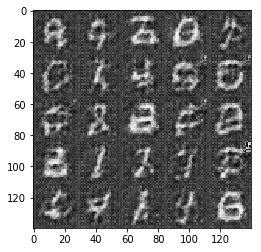

Epoch 2/5... Batch 210... Discriminator Loss: 0.5811... Generator Loss: 1.7816
Epoch 2/5... Batch 220... Discriminator Loss: 0.4672... Generator Loss: 2.5547
Epoch 2/5... Batch 230... Discriminator Loss: 0.4481... Generator Loss: 4.3313
Epoch 3/5... Batch 10... Discriminator Loss: 1.6398... Generator Loss: 1.8817
Epoch 3/5... Batch 20... Discriminator Loss: 1.4077... Generator Loss: 0.5065
Epoch 3/5... Batch 30... Discriminator Loss: 1.6170... Generator Loss: 0.4300
Epoch 3/5... Batch 40... Discriminator Loss: 1.1176... Generator Loss: 0.8383
Epoch 3/5... Batch 50... Discriminator Loss: 1.2307... Generator Loss: 0.6889
Epoch 3/5... Batch 60... Discriminator Loss: 1.3597... Generator Loss: 0.5361
Epoch 3/5... Batch 70... Discriminator Loss: 1.2424... Generator Loss: 0.6416
Epoch 3/5... Batch 80... Discriminator Loss: 1.9432... Generator Loss: 0.2843
Epoch 3/5... Batch 90... Discriminator Loss: 1.0366... Generator Loss: 2.2706
Epoch 3/5... Batch 100... Discriminator Loss: 0.7367... Gener

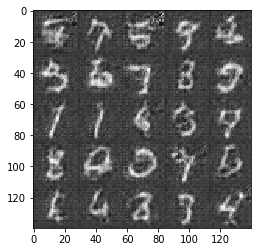

Epoch 3/5... Batch 110... Discriminator Loss: 0.6661... Generator Loss: 1.5028
Epoch 3/5... Batch 120... Discriminator Loss: 0.9894... Generator Loss: 1.2352
Epoch 3/5... Batch 130... Discriminator Loss: 1.0687... Generator Loss: 2.0167
Epoch 3/5... Batch 140... Discriminator Loss: 0.5640... Generator Loss: 2.0535
Epoch 3/5... Batch 150... Discriminator Loss: 0.4976... Generator Loss: 2.9951
Epoch 3/5... Batch 160... Discriminator Loss: 0.3558... Generator Loss: 4.6628
Epoch 3/5... Batch 170... Discriminator Loss: 0.4304... Generator Loss: 3.2921
Epoch 3/5... Batch 180... Discriminator Loss: 0.5151... Generator Loss: 3.9270
Epoch 3/5... Batch 190... Discriminator Loss: 1.3998... Generator Loss: 1.8285
Epoch 3/5... Batch 200... Discriminator Loss: 1.1186... Generator Loss: 0.7844


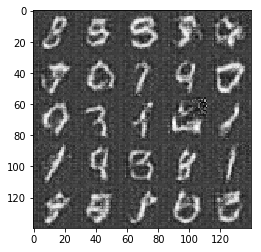

Epoch 3/5... Batch 210... Discriminator Loss: 1.2450... Generator Loss: 1.0382
Epoch 3/5... Batch 220... Discriminator Loss: 1.0144... Generator Loss: 1.1341
Epoch 3/5... Batch 230... Discriminator Loss: 1.2233... Generator Loss: 0.6215
Epoch 4/5... Batch 10... Discriminator Loss: 0.9667... Generator Loss: 0.9415
Epoch 4/5... Batch 20... Discriminator Loss: 1.3087... Generator Loss: 0.5805
Epoch 4/5... Batch 30... Discriminator Loss: 0.7672... Generator Loss: 1.9667
Epoch 4/5... Batch 40... Discriminator Loss: 0.7022... Generator Loss: 1.3809
Epoch 4/5... Batch 50... Discriminator Loss: 1.2679... Generator Loss: 0.6356
Epoch 4/5... Batch 60... Discriminator Loss: 0.8693... Generator Loss: 1.4763
Epoch 4/5... Batch 70... Discriminator Loss: 2.5313... Generator Loss: 0.1667
Epoch 4/5... Batch 80... Discriminator Loss: 0.6682... Generator Loss: 1.5194
Epoch 4/5... Batch 90... Discriminator Loss: 0.6577... Generator Loss: 2.9409
Epoch 4/5... Batch 100... Discriminator Loss: 0.8496... Gener

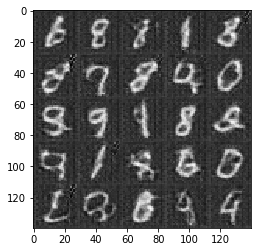

Epoch 4/5... Batch 110... Discriminator Loss: 0.4994... Generator Loss: 2.1793
Epoch 4/5... Batch 120... Discriminator Loss: 0.4151... Generator Loss: 3.0886
Epoch 4/5... Batch 130... Discriminator Loss: 0.3890... Generator Loss: 3.3846
Epoch 4/5... Batch 140... Discriminator Loss: 0.3717... Generator Loss: 3.7301
Epoch 4/5... Batch 150... Discriminator Loss: 0.3631... Generator Loss: 4.5714
Epoch 4/5... Batch 160... Discriminator Loss: 1.0273... Generator Loss: 1.2346
Epoch 4/5... Batch 170... Discriminator Loss: 0.8954... Generator Loss: 1.0420
Epoch 4/5... Batch 180... Discriminator Loss: 0.8955... Generator Loss: 1.5500
Epoch 4/5... Batch 190... Discriminator Loss: 0.8906... Generator Loss: 2.0550
Epoch 4/5... Batch 200... Discriminator Loss: 0.6667... Generator Loss: 3.4560


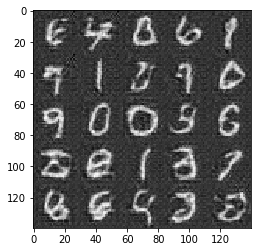

Epoch 4/5... Batch 210... Discriminator Loss: 0.9915... Generator Loss: 0.9299
Epoch 4/5... Batch 220... Discriminator Loss: 2.1477... Generator Loss: 2.4145
Epoch 4/5... Batch 230... Discriminator Loss: 0.6137... Generator Loss: 2.1809
Epoch 5/5... Batch 10... Discriminator Loss: 0.7475... Generator Loss: 1.2475
Epoch 5/5... Batch 20... Discriminator Loss: 1.1604... Generator Loss: 3.4093
Epoch 5/5... Batch 30... Discriminator Loss: 0.8114... Generator Loss: 1.3732
Epoch 5/5... Batch 40... Discriminator Loss: 0.5556... Generator Loss: 2.5810
Epoch 5/5... Batch 50... Discriminator Loss: 0.4677... Generator Loss: 2.3537
Epoch 5/5... Batch 60... Discriminator Loss: 0.4006... Generator Loss: 3.3058
Epoch 5/5... Batch 70... Discriminator Loss: 0.3859... Generator Loss: 3.6101
Epoch 5/5... Batch 80... Discriminator Loss: 0.3628... Generator Loss: 3.9370
Epoch 5/5... Batch 90... Discriminator Loss: 0.3532... Generator Loss: 4.9045
Epoch 5/5... Batch 100... Discriminator Loss: 0.6736... Gener

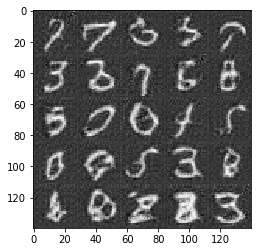

Epoch 5/5... Batch 110... Discriminator Loss: 0.4481... Generator Loss: 2.6522
Epoch 5/5... Batch 120... Discriminator Loss: 1.3605... Generator Loss: 1.9794
Epoch 5/5... Batch 130... Discriminator Loss: 0.8145... Generator Loss: 1.7251
Epoch 5/5... Batch 140... Discriminator Loss: 0.4925... Generator Loss: 2.1623
Epoch 5/5... Batch 150... Discriminator Loss: 0.4098... Generator Loss: 3.6085
Epoch 5/5... Batch 160... Discriminator Loss: 1.1724... Generator Loss: 2.0165
Epoch 5/5... Batch 170... Discriminator Loss: 0.8070... Generator Loss: 1.6738
Epoch 5/5... Batch 180... Discriminator Loss: 0.9614... Generator Loss: 0.8965
Epoch 5/5... Batch 190... Discriminator Loss: 0.5583... Generator Loss: 1.9989
Epoch 5/5... Batch 200... Discriminator Loss: 2.3235... Generator Loss: 0.2492


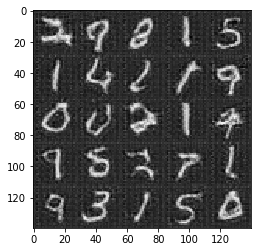

Epoch 5/5... Batch 210... Discriminator Loss: 0.9553... Generator Loss: 0.9897
Epoch 5/5... Batch 220... Discriminator Loss: 0.5859... Generator Loss: 1.7635
Epoch 5/5... Batch 230... Discriminator Loss: 0.5888... Generator Loss: 1.7514


In [13]:
batch_size = 256
z_dim = 128
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Batch 10... Discriminator Loss: 0.4787... Generator Loss: 4.2923
Epoch 1/2... Batch 20... Discriminator Loss: 3.1481... Generator Loss: 0.1288
Epoch 1/2... Batch 30... Discriminator Loss: 0.9553... Generator Loss: 1.3393
Epoch 1/2... Batch 40... Discriminator Loss: 1.6686... Generator Loss: 3.8702
Epoch 1/2... Batch 50... Discriminator Loss: 1.2420... Generator Loss: 4.0268
Epoch 1/2... Batch 60... Discriminator Loss: 0.6109... Generator Loss: 1.7113
Epoch 1/2... Batch 70... Discriminator Loss: 0.8541... Generator Loss: 2.2877
Epoch 1/2... Batch 80... Discriminator Loss: 0.6491... Generator Loss: 1.8600
Epoch 1/2... Batch 90... Discriminator Loss: 0.6443... Generator Loss: 1.6328
Epoch 1/2... Batch 100... Discriminator Loss: 0.3797... Generator Loss: 3.5303


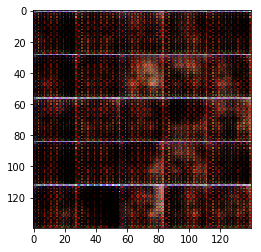

Epoch 1/2... Batch 110... Discriminator Loss: 4.9680... Generator Loss: 7.4943
Epoch 1/2... Batch 120... Discriminator Loss: 1.2447... Generator Loss: 2.6309
Epoch 1/2... Batch 130... Discriminator Loss: 0.8722... Generator Loss: 2.0358
Epoch 1/2... Batch 140... Discriminator Loss: 3.9218... Generator Loss: 3.9200
Epoch 1/2... Batch 150... Discriminator Loss: 0.7522... Generator Loss: 1.6639
Epoch 1/2... Batch 160... Discriminator Loss: 0.5891... Generator Loss: 1.6263
Epoch 1/2... Batch 170... Discriminator Loss: 0.6248... Generator Loss: 1.6327
Epoch 1/2... Batch 180... Discriminator Loss: 2.1894... Generator Loss: 2.2102
Epoch 1/2... Batch 190... Discriminator Loss: 1.2587... Generator Loss: 1.1515
Epoch 1/2... Batch 200... Discriminator Loss: 0.9813... Generator Loss: 0.9449


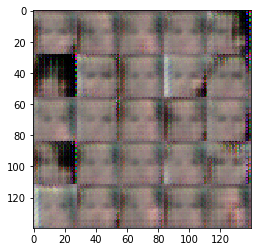

Epoch 1/2... Batch 210... Discriminator Loss: 0.5801... Generator Loss: 2.0051
Epoch 1/2... Batch 220... Discriminator Loss: 0.5868... Generator Loss: 2.0280
Epoch 1/2... Batch 230... Discriminator Loss: 1.0422... Generator Loss: 0.8107
Epoch 1/2... Batch 240... Discriminator Loss: 0.6649... Generator Loss: 2.2872
Epoch 1/2... Batch 250... Discriminator Loss: 2.1361... Generator Loss: 2.3317
Epoch 1/2... Batch 260... Discriminator Loss: 1.8761... Generator Loss: 0.8502
Epoch 1/2... Batch 270... Discriminator Loss: 1.8427... Generator Loss: 0.4396
Epoch 1/2... Batch 280... Discriminator Loss: 0.7524... Generator Loss: 1.1888
Epoch 1/2... Batch 290... Discriminator Loss: 1.6985... Generator Loss: 1.2004
Epoch 1/2... Batch 300... Discriminator Loss: 0.9941... Generator Loss: 1.2621


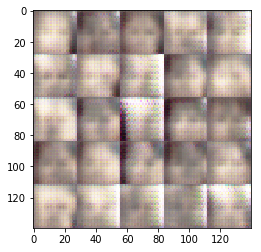

Epoch 1/2... Batch 310... Discriminator Loss: 1.3820... Generator Loss: 1.7167
Epoch 1/2... Batch 320... Discriminator Loss: 1.5440... Generator Loss: 2.4214
Epoch 1/2... Batch 330... Discriminator Loss: 1.6741... Generator Loss: 0.5153
Epoch 1/2... Batch 340... Discriminator Loss: 1.3006... Generator Loss: 0.6535
Epoch 1/2... Batch 350... Discriminator Loss: 1.6307... Generator Loss: 0.4401
Epoch 1/2... Batch 360... Discriminator Loss: 1.7423... Generator Loss: 0.3573
Epoch 1/2... Batch 370... Discriminator Loss: 1.2319... Generator Loss: 1.2797
Epoch 1/2... Batch 380... Discriminator Loss: 1.5567... Generator Loss: 0.5249
Epoch 1/2... Batch 390... Discriminator Loss: 1.0834... Generator Loss: 0.9654
Epoch 1/2... Batch 400... Discriminator Loss: 1.1834... Generator Loss: 1.4073


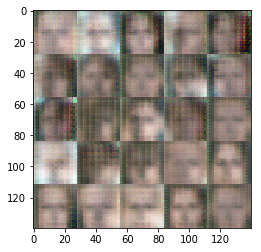

Epoch 1/2... Batch 410... Discriminator Loss: 1.3133... Generator Loss: 0.9446
Epoch 1/2... Batch 420... Discriminator Loss: 1.1449... Generator Loss: 2.2969
Epoch 1/2... Batch 430... Discriminator Loss: 1.4769... Generator Loss: 0.4865
Epoch 1/2... Batch 440... Discriminator Loss: 1.2952... Generator Loss: 0.9748
Epoch 1/2... Batch 450... Discriminator Loss: 0.7815... Generator Loss: 1.6383
Epoch 1/2... Batch 460... Discriminator Loss: 1.0757... Generator Loss: 1.7444
Epoch 1/2... Batch 470... Discriminator Loss: 1.1216... Generator Loss: 1.6874
Epoch 1/2... Batch 480... Discriminator Loss: 1.5744... Generator Loss: 0.4302
Epoch 1/2... Batch 490... Discriminator Loss: 0.9564... Generator Loss: 1.9242
Epoch 1/2... Batch 500... Discriminator Loss: 1.2972... Generator Loss: 1.5776


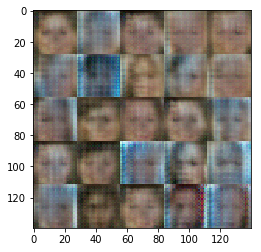

Epoch 1/2... Batch 510... Discriminator Loss: 1.4298... Generator Loss: 0.5645
Epoch 1/2... Batch 520... Discriminator Loss: 1.0387... Generator Loss: 1.6854
Epoch 1/2... Batch 530... Discriminator Loss: 1.3323... Generator Loss: 0.5896
Epoch 1/2... Batch 540... Discriminator Loss: 0.7466... Generator Loss: 1.3073
Epoch 1/2... Batch 550... Discriminator Loss: 0.9129... Generator Loss: 1.3447
Epoch 1/2... Batch 560... Discriminator Loss: 1.1294... Generator Loss: 0.7989
Epoch 1/2... Batch 570... Discriminator Loss: 0.9733... Generator Loss: 2.1329
Epoch 1/2... Batch 580... Discriminator Loss: 0.9801... Generator Loss: 0.9916
Epoch 1/2... Batch 590... Discriminator Loss: 1.2439... Generator Loss: 1.7898
Epoch 1/2... Batch 600... Discriminator Loss: 1.1352... Generator Loss: 0.8146


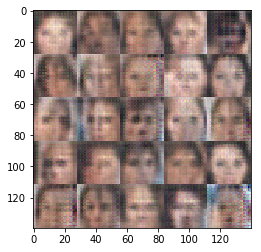

Epoch 1/2... Batch 610... Discriminator Loss: 1.1311... Generator Loss: 1.6673
Epoch 1/2... Batch 620... Discriminator Loss: 1.2368... Generator Loss: 0.7143
Epoch 1/2... Batch 630... Discriminator Loss: 1.0717... Generator Loss: 0.7701
Epoch 1/2... Batch 640... Discriminator Loss: 0.9997... Generator Loss: 0.8560
Epoch 1/2... Batch 650... Discriminator Loss: 1.1376... Generator Loss: 1.3939
Epoch 1/2... Batch 660... Discriminator Loss: 1.3587... Generator Loss: 0.6800
Epoch 1/2... Batch 670... Discriminator Loss: 1.1119... Generator Loss: 1.5708
Epoch 1/2... Batch 680... Discriminator Loss: 1.6190... Generator Loss: 1.8350
Epoch 1/2... Batch 690... Discriminator Loss: 1.1819... Generator Loss: 2.0304
Epoch 1/2... Batch 700... Discriminator Loss: 1.4181... Generator Loss: 1.9278


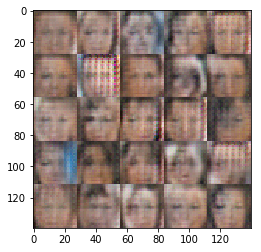

Epoch 1/2... Batch 710... Discriminator Loss: 1.1621... Generator Loss: 1.1951
Epoch 1/2... Batch 720... Discriminator Loss: 1.4614... Generator Loss: 0.7471
Epoch 1/2... Batch 730... Discriminator Loss: 1.1805... Generator Loss: 0.9927
Epoch 1/2... Batch 740... Discriminator Loss: 0.9296... Generator Loss: 0.8949
Epoch 1/2... Batch 750... Discriminator Loss: 0.9424... Generator Loss: 1.2104
Epoch 1/2... Batch 760... Discriminator Loss: 0.8954... Generator Loss: 1.2979
Epoch 1/2... Batch 770... Discriminator Loss: 1.2358... Generator Loss: 1.3522
Epoch 1/2... Batch 780... Discriminator Loss: 1.5244... Generator Loss: 0.5044
Epoch 1/2... Batch 790... Discriminator Loss: 1.0107... Generator Loss: 1.0804
Epoch 1/2... Batch 800... Discriminator Loss: 1.0129... Generator Loss: 1.1349


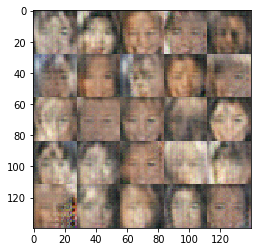

Epoch 1/2... Batch 810... Discriminator Loss: 1.3784... Generator Loss: 1.1869
Epoch 1/2... Batch 820... Discriminator Loss: 0.9636... Generator Loss: 1.5709
Epoch 1/2... Batch 830... Discriminator Loss: 1.0240... Generator Loss: 1.7568
Epoch 1/2... Batch 840... Discriminator Loss: 0.9560... Generator Loss: 1.1765
Epoch 1/2... Batch 850... Discriminator Loss: 1.6555... Generator Loss: 0.4866
Epoch 1/2... Batch 860... Discriminator Loss: 1.3535... Generator Loss: 0.8704
Epoch 1/2... Batch 870... Discriminator Loss: 1.1478... Generator Loss: 0.8409
Epoch 1/2... Batch 880... Discriminator Loss: 1.1547... Generator Loss: 0.9051
Epoch 1/2... Batch 890... Discriminator Loss: 1.0817... Generator Loss: 1.4259
Epoch 1/2... Batch 900... Discriminator Loss: 1.2895... Generator Loss: 0.6747


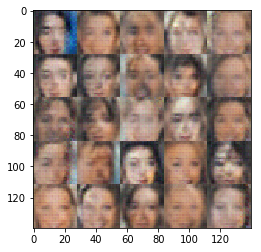

Epoch 1/2... Batch 910... Discriminator Loss: 1.4835... Generator Loss: 0.6563
Epoch 1/2... Batch 920... Discriminator Loss: 1.0938... Generator Loss: 0.8443
Epoch 1/2... Batch 930... Discriminator Loss: 1.0247... Generator Loss: 1.1211
Epoch 1/2... Batch 940... Discriminator Loss: 1.2665... Generator Loss: 0.7847
Epoch 1/2... Batch 950... Discriminator Loss: 1.2482... Generator Loss: 1.4663
Epoch 1/2... Batch 960... Discriminator Loss: 1.1040... Generator Loss: 0.9819
Epoch 1/2... Batch 970... Discriminator Loss: 5.2981... Generator Loss: 4.1207
Epoch 1/2... Batch 980... Discriminator Loss: 1.3551... Generator Loss: 0.8749
Epoch 1/2... Batch 990... Discriminator Loss: 1.6349... Generator Loss: 0.4889
Epoch 1/2... Batch 1000... Discriminator Loss: 1.3043... Generator Loss: 0.7746


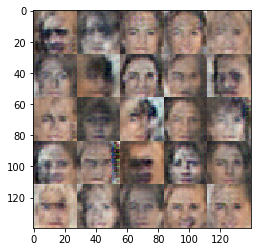

Epoch 1/2... Batch 1010... Discriminator Loss: 1.2933... Generator Loss: 1.5420
Epoch 1/2... Batch 1020... Discriminator Loss: 1.1618... Generator Loss: 0.8232
Epoch 1/2... Batch 1030... Discriminator Loss: 1.3105... Generator Loss: 0.5903
Epoch 1/2... Batch 1040... Discriminator Loss: 1.2728... Generator Loss: 0.7148
Epoch 1/2... Batch 1050... Discriminator Loss: 1.3332... Generator Loss: 0.6210
Epoch 1/2... Batch 1060... Discriminator Loss: 0.8072... Generator Loss: 1.1333
Epoch 1/2... Batch 1070... Discriminator Loss: 1.6731... Generator Loss: 0.6322
Epoch 1/2... Batch 1080... Discriminator Loss: 1.2451... Generator Loss: 0.9249
Epoch 1/2... Batch 1090... Discriminator Loss: 1.2767... Generator Loss: 0.7086
Epoch 1/2... Batch 1100... Discriminator Loss: 1.4673... Generator Loss: 0.6104


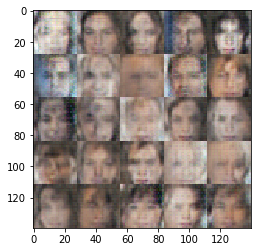

Epoch 1/2... Batch 1110... Discriminator Loss: 1.8376... Generator Loss: 1.7704
Epoch 1/2... Batch 1120... Discriminator Loss: 1.2651... Generator Loss: 0.8055
Epoch 1/2... Batch 1130... Discriminator Loss: 1.3933... Generator Loss: 0.7728
Epoch 1/2... Batch 1140... Discriminator Loss: 1.1440... Generator Loss: 0.8589
Epoch 1/2... Batch 1150... Discriminator Loss: 1.2856... Generator Loss: 0.8231
Epoch 1/2... Batch 1160... Discriminator Loss: 1.0182... Generator Loss: 0.8531
Epoch 1/2... Batch 1170... Discriminator Loss: 0.9869... Generator Loss: 0.9649
Epoch 1/2... Batch 1180... Discriminator Loss: 1.4924... Generator Loss: 0.8477
Epoch 1/2... Batch 1190... Discriminator Loss: 1.5219... Generator Loss: 0.8681
Epoch 1/2... Batch 1200... Discriminator Loss: 1.0436... Generator Loss: 0.9243


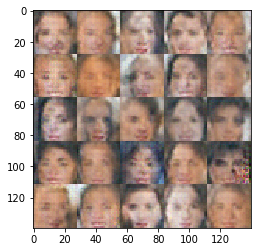

Epoch 1/2... Batch 1210... Discriminator Loss: 1.0420... Generator Loss: 1.2063
Epoch 1/2... Batch 1220... Discriminator Loss: 1.5930... Generator Loss: 0.7180
Epoch 1/2... Batch 1230... Discriminator Loss: 0.7443... Generator Loss: 2.1828
Epoch 1/2... Batch 1240... Discriminator Loss: 1.2006... Generator Loss: 0.7323
Epoch 1/2... Batch 1250... Discriminator Loss: 2.1396... Generator Loss: 2.3080
Epoch 1/2... Batch 1260... Discriminator Loss: 1.0741... Generator Loss: 1.0628
Epoch 1/2... Batch 1270... Discriminator Loss: 1.3639... Generator Loss: 0.8250
Epoch 1/2... Batch 1280... Discriminator Loss: 1.3261... Generator Loss: 1.6126
Epoch 1/2... Batch 1290... Discriminator Loss: 0.8398... Generator Loss: 1.3538
Epoch 1/2... Batch 1300... Discriminator Loss: 1.5585... Generator Loss: 1.2642


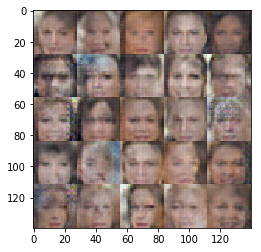

Epoch 1/2... Batch 1310... Discriminator Loss: 1.4501... Generator Loss: 0.6617
Epoch 1/2... Batch 1320... Discriminator Loss: 1.0405... Generator Loss: 0.8301
Epoch 1/2... Batch 1330... Discriminator Loss: 0.8931... Generator Loss: 1.0837
Epoch 1/2... Batch 1340... Discriminator Loss: 1.1822... Generator Loss: 0.9324
Epoch 1/2... Batch 1350... Discriminator Loss: 1.0671... Generator Loss: 1.0928
Epoch 1/2... Batch 1360... Discriminator Loss: 0.8866... Generator Loss: 1.6058
Epoch 1/2... Batch 1370... Discriminator Loss: 1.7256... Generator Loss: 0.5661
Epoch 1/2... Batch 1380... Discriminator Loss: 1.1780... Generator Loss: 1.0430
Epoch 1/2... Batch 1390... Discriminator Loss: 1.3020... Generator Loss: 0.8378
Epoch 1/2... Batch 1400... Discriminator Loss: 1.3747... Generator Loss: 1.6103


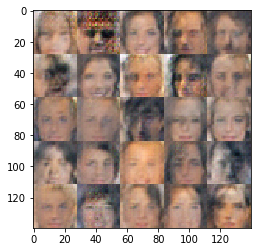

Epoch 1/2... Batch 1410... Discriminator Loss: 1.0860... Generator Loss: 0.9936
Epoch 1/2... Batch 1420... Discriminator Loss: 1.2552... Generator Loss: 0.9234
Epoch 1/2... Batch 1430... Discriminator Loss: 1.0912... Generator Loss: 0.8140
Epoch 1/2... Batch 1440... Discriminator Loss: 1.2249... Generator Loss: 1.2290
Epoch 1/2... Batch 1450... Discriminator Loss: 0.9000... Generator Loss: 0.9091
Epoch 1/2... Batch 1460... Discriminator Loss: 1.1297... Generator Loss: 0.9361
Epoch 1/2... Batch 1470... Discriminator Loss: 1.3189... Generator Loss: 0.7908
Epoch 1/2... Batch 1480... Discriminator Loss: 1.3624... Generator Loss: 0.8866
Epoch 1/2... Batch 1490... Discriminator Loss: 1.0368... Generator Loss: 0.8088
Epoch 1/2... Batch 1500... Discriminator Loss: 1.1695... Generator Loss: 1.3692


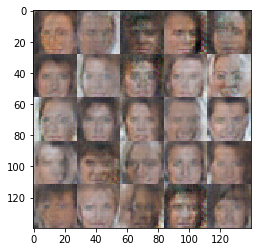

Epoch 1/2... Batch 1510... Discriminator Loss: 1.3319... Generator Loss: 1.0979
Epoch 1/2... Batch 1520... Discriminator Loss: 1.3285... Generator Loss: 1.1716
Epoch 1/2... Batch 1530... Discriminator Loss: 1.3411... Generator Loss: 1.1831
Epoch 1/2... Batch 1540... Discriminator Loss: 1.2844... Generator Loss: 1.1287
Epoch 1/2... Batch 1550... Discriminator Loss: 1.3137... Generator Loss: 0.6499
Epoch 1/2... Batch 1560... Discriminator Loss: 1.0673... Generator Loss: 1.2683
Epoch 1/2... Batch 1570... Discriminator Loss: 1.0867... Generator Loss: 0.8534
Epoch 1/2... Batch 1580... Discriminator Loss: 1.1700... Generator Loss: 1.2308
Epoch 2/2... Batch 10... Discriminator Loss: 1.3537... Generator Loss: 1.4900
Epoch 2/2... Batch 20... Discriminator Loss: 1.0889... Generator Loss: 0.9217
Epoch 2/2... Batch 30... Discriminator Loss: 1.1959... Generator Loss: 0.7320
Epoch 2/2... Batch 40... Discriminator Loss: 1.0191... Generator Loss: 0.9344
Epoch 2/2... Batch 50... Discriminator Loss: 1.9

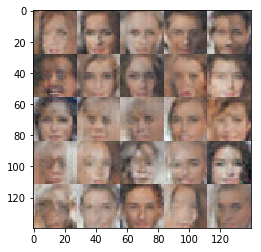

Epoch 2/2... Batch 110... Discriminator Loss: 1.1342... Generator Loss: 0.9667
Epoch 2/2... Batch 120... Discriminator Loss: 1.0918... Generator Loss: 0.7259
Epoch 2/2... Batch 130... Discriminator Loss: 1.2945... Generator Loss: 1.7344
Epoch 2/2... Batch 140... Discriminator Loss: 1.1773... Generator Loss: 1.2120
Epoch 2/2... Batch 150... Discriminator Loss: 0.7540... Generator Loss: 1.7501
Epoch 2/2... Batch 160... Discriminator Loss: 0.9906... Generator Loss: 1.1392
Epoch 2/2... Batch 170... Discriminator Loss: 1.8999... Generator Loss: 0.3755
Epoch 2/2... Batch 180... Discriminator Loss: 1.0525... Generator Loss: 0.9465
Epoch 2/2... Batch 190... Discriminator Loss: 1.3937... Generator Loss: 0.6606
Epoch 2/2... Batch 200... Discriminator Loss: 1.6911... Generator Loss: 0.5373


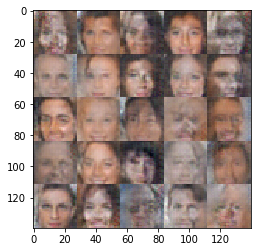

Epoch 2/2... Batch 210... Discriminator Loss: 0.8962... Generator Loss: 1.3929
Epoch 2/2... Batch 220... Discriminator Loss: 0.6765... Generator Loss: 1.3408
Epoch 2/2... Batch 230... Discriminator Loss: 2.2875... Generator Loss: 2.4477
Epoch 2/2... Batch 240... Discriminator Loss: 1.3001... Generator Loss: 0.7056
Epoch 2/2... Batch 250... Discriminator Loss: 1.1864... Generator Loss: 0.7811
Epoch 2/2... Batch 260... Discriminator Loss: 1.3739... Generator Loss: 1.5431
Epoch 2/2... Batch 270... Discriminator Loss: 0.9349... Generator Loss: 1.0537
Epoch 2/2... Batch 280... Discriminator Loss: 1.3259... Generator Loss: 1.1053
Epoch 2/2... Batch 290... Discriminator Loss: 1.1456... Generator Loss: 0.9880
Epoch 2/2... Batch 300... Discriminator Loss: 1.0621... Generator Loss: 0.8260


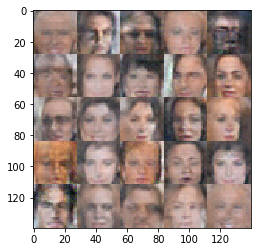

Epoch 2/2... Batch 310... Discriminator Loss: 0.9425... Generator Loss: 1.2899
Epoch 2/2... Batch 320... Discriminator Loss: 1.1570... Generator Loss: 0.6702
Epoch 2/2... Batch 330... Discriminator Loss: 1.2160... Generator Loss: 1.1456
Epoch 2/2... Batch 340... Discriminator Loss: 0.9533... Generator Loss: 0.9498
Epoch 2/2... Batch 350... Discriminator Loss: 1.2928... Generator Loss: 0.5867
Epoch 2/2... Batch 360... Discriminator Loss: 1.1196... Generator Loss: 0.7554
Epoch 2/2... Batch 370... Discriminator Loss: 1.2941... Generator Loss: 0.7258
Epoch 2/2... Batch 380... Discriminator Loss: 0.9310... Generator Loss: 1.0021
Epoch 2/2... Batch 390... Discriminator Loss: 0.7802... Generator Loss: 1.0704
Epoch 2/2... Batch 400... Discriminator Loss: 0.7726... Generator Loss: 1.1600


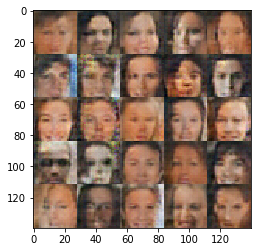

Epoch 2/2... Batch 410... Discriminator Loss: 1.1182... Generator Loss: 1.4517
Epoch 2/2... Batch 420... Discriminator Loss: 1.1465... Generator Loss: 0.8341
Epoch 2/2... Batch 430... Discriminator Loss: 1.0764... Generator Loss: 1.0315
Epoch 2/2... Batch 440... Discriminator Loss: 1.1461... Generator Loss: 0.8182
Epoch 2/2... Batch 450... Discriminator Loss: 0.9257... Generator Loss: 1.3013
Epoch 2/2... Batch 460... Discriminator Loss: 1.4410... Generator Loss: 2.3641
Epoch 2/2... Batch 470... Discriminator Loss: 1.3716... Generator Loss: 1.2233
Epoch 2/2... Batch 480... Discriminator Loss: 1.0018... Generator Loss: 0.8704
Epoch 2/2... Batch 490... Discriminator Loss: 1.1099... Generator Loss: 1.1537
Epoch 2/2... Batch 500... Discriminator Loss: 1.1915... Generator Loss: 1.6464


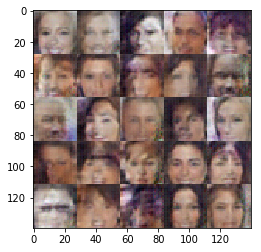

Epoch 2/2... Batch 510... Discriminator Loss: 1.5958... Generator Loss: 0.4095
Epoch 2/2... Batch 520... Discriminator Loss: 1.5275... Generator Loss: 1.9210
Epoch 2/2... Batch 530... Discriminator Loss: 1.2839... Generator Loss: 1.3196
Epoch 2/2... Batch 540... Discriminator Loss: 0.7933... Generator Loss: 1.4857
Epoch 2/2... Batch 550... Discriminator Loss: 1.0540... Generator Loss: 1.3756
Epoch 2/2... Batch 560... Discriminator Loss: 1.1685... Generator Loss: 1.0937
Epoch 2/2... Batch 570... Discriminator Loss: 2.5778... Generator Loss: 0.2711
Epoch 2/2... Batch 580... Discriminator Loss: 0.9958... Generator Loss: 1.4476
Epoch 2/2... Batch 590... Discriminator Loss: 1.7222... Generator Loss: 2.4021
Epoch 2/2... Batch 600... Discriminator Loss: 1.4422... Generator Loss: 0.9123


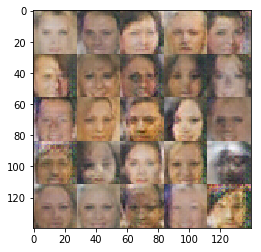

Epoch 2/2... Batch 610... Discriminator Loss: 2.5807... Generator Loss: 0.1588
Epoch 2/2... Batch 620... Discriminator Loss: 0.7675... Generator Loss: 1.4418
Epoch 2/2... Batch 630... Discriminator Loss: 1.1479... Generator Loss: 1.7283
Epoch 2/2... Batch 640... Discriminator Loss: 0.5097... Generator Loss: 2.5517
Epoch 2/2... Batch 650... Discriminator Loss: 1.7178... Generator Loss: 0.3524
Epoch 2/2... Batch 660... Discriminator Loss: 1.3299... Generator Loss: 1.4545
Epoch 2/2... Batch 670... Discriminator Loss: 0.9730... Generator Loss: 1.1439
Epoch 2/2... Batch 680... Discriminator Loss: 1.0451... Generator Loss: 0.9255
Epoch 2/2... Batch 690... Discriminator Loss: 0.9877... Generator Loss: 0.9029
Epoch 2/2... Batch 700... Discriminator Loss: 1.3379... Generator Loss: 0.5751


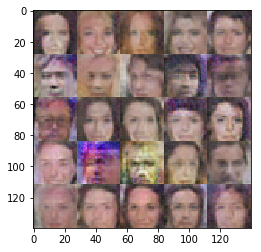

Epoch 2/2... Batch 710... Discriminator Loss: 1.1154... Generator Loss: 1.4929
Epoch 2/2... Batch 720... Discriminator Loss: 1.0470... Generator Loss: 0.8857
Epoch 2/2... Batch 730... Discriminator Loss: 0.9214... Generator Loss: 1.7755
Epoch 2/2... Batch 740... Discriminator Loss: 0.6352... Generator Loss: 2.3800
Epoch 2/2... Batch 750... Discriminator Loss: 1.2922... Generator Loss: 0.8424
Epoch 2/2... Batch 760... Discriminator Loss: 1.6171... Generator Loss: 0.7726
Epoch 2/2... Batch 770... Discriminator Loss: 1.3041... Generator Loss: 1.1192
Epoch 2/2... Batch 780... Discriminator Loss: 1.1359... Generator Loss: 0.8617
Epoch 2/2... Batch 790... Discriminator Loss: 1.2527... Generator Loss: 0.9078
Epoch 2/2... Batch 800... Discriminator Loss: 1.2255... Generator Loss: 1.0493


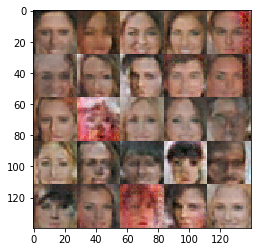

Epoch 2/2... Batch 810... Discriminator Loss: 1.2639... Generator Loss: 1.0507
Epoch 2/2... Batch 820... Discriminator Loss: 1.4769... Generator Loss: 1.3121
Epoch 2/2... Batch 830... Discriminator Loss: 1.1745... Generator Loss: 0.8652
Epoch 2/2... Batch 840... Discriminator Loss: 1.0907... Generator Loss: 1.0301
Epoch 2/2... Batch 850... Discriminator Loss: 1.1227... Generator Loss: 0.9629
Epoch 2/2... Batch 860... Discriminator Loss: 1.2211... Generator Loss: 1.1582
Epoch 2/2... Batch 870... Discriminator Loss: 0.9710... Generator Loss: 1.1342
Epoch 2/2... Batch 880... Discriminator Loss: 0.8972... Generator Loss: 1.3390
Epoch 2/2... Batch 890... Discriminator Loss: 1.6124... Generator Loss: 0.5794
Epoch 2/2... Batch 900... Discriminator Loss: 1.1790... Generator Loss: 0.9250


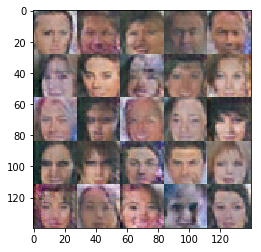

Epoch 2/2... Batch 910... Discriminator Loss: 1.5373... Generator Loss: 1.5628
Epoch 2/2... Batch 920... Discriminator Loss: 1.4175... Generator Loss: 0.9737
Epoch 2/2... Batch 930... Discriminator Loss: 1.1477... Generator Loss: 0.7412
Epoch 2/2... Batch 940... Discriminator Loss: 1.2353... Generator Loss: 0.7154
Epoch 2/2... Batch 950... Discriminator Loss: 1.2383... Generator Loss: 1.5497
Epoch 2/2... Batch 960... Discriminator Loss: 1.3219... Generator Loss: 0.6557
Epoch 2/2... Batch 970... Discriminator Loss: 0.9864... Generator Loss: 0.7752
Epoch 2/2... Batch 980... Discriminator Loss: 0.9150... Generator Loss: 2.1048
Epoch 2/2... Batch 990... Discriminator Loss: 1.2556... Generator Loss: 1.1226
Epoch 2/2... Batch 1000... Discriminator Loss: 1.3776... Generator Loss: 1.0035


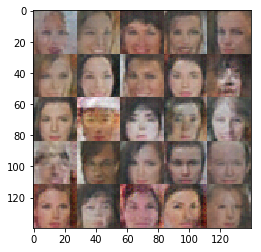

Epoch 2/2... Batch 1010... Discriminator Loss: 0.9541... Generator Loss: 1.0882
Epoch 2/2... Batch 1020... Discriminator Loss: 1.2850... Generator Loss: 1.1683
Epoch 2/2... Batch 1030... Discriminator Loss: 1.1094... Generator Loss: 0.9989
Epoch 2/2... Batch 1040... Discriminator Loss: 1.3417... Generator Loss: 1.2438
Epoch 2/2... Batch 1050... Discriminator Loss: 1.1417... Generator Loss: 0.9575
Epoch 2/2... Batch 1060... Discriminator Loss: 1.2128... Generator Loss: 0.5940
Epoch 2/2... Batch 1070... Discriminator Loss: 1.7067... Generator Loss: 0.9986
Epoch 2/2... Batch 1080... Discriminator Loss: 1.2524... Generator Loss: 1.0340
Epoch 2/2... Batch 1090... Discriminator Loss: 1.1523... Generator Loss: 1.0732
Epoch 2/2... Batch 1100... Discriminator Loss: 1.1465... Generator Loss: 0.8184


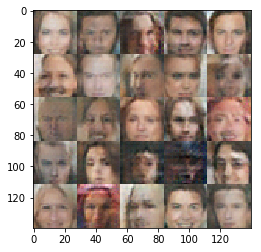

Epoch 2/2... Batch 1110... Discriminator Loss: 1.5903... Generator Loss: 0.7182
Epoch 2/2... Batch 1120... Discriminator Loss: 1.0503... Generator Loss: 1.0862
Epoch 2/2... Batch 1130... Discriminator Loss: 1.0969... Generator Loss: 0.9096
Epoch 2/2... Batch 1140... Discriminator Loss: 1.4298... Generator Loss: 0.7951
Epoch 2/2... Batch 1150... Discriminator Loss: 1.3036... Generator Loss: 0.9959
Epoch 2/2... Batch 1160... Discriminator Loss: 1.2096... Generator Loss: 0.7107
Epoch 2/2... Batch 1170... Discriminator Loss: 1.2768... Generator Loss: 0.8032
Epoch 2/2... Batch 1180... Discriminator Loss: 1.2751... Generator Loss: 0.8262
Epoch 2/2... Batch 1190... Discriminator Loss: 1.1916... Generator Loss: 0.8774
Epoch 2/2... Batch 1200... Discriminator Loss: 1.4450... Generator Loss: 0.5353


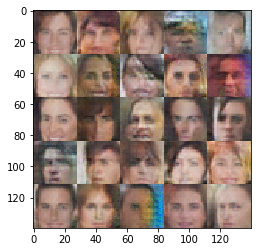

Epoch 2/2... Batch 1210... Discriminator Loss: 1.2429... Generator Loss: 1.0728
Epoch 2/2... Batch 1220... Discriminator Loss: 1.3370... Generator Loss: 0.8035
Epoch 2/2... Batch 1230... Discriminator Loss: 1.1934... Generator Loss: 0.8904
Epoch 2/2... Batch 1240... Discriminator Loss: 1.2594... Generator Loss: 0.9300
Epoch 2/2... Batch 1250... Discriminator Loss: 1.1566... Generator Loss: 0.8699
Epoch 2/2... Batch 1260... Discriminator Loss: 1.3400... Generator Loss: 0.9715
Epoch 2/2... Batch 1270... Discriminator Loss: 1.2580... Generator Loss: 1.0585
Epoch 2/2... Batch 1280... Discriminator Loss: 1.3379... Generator Loss: 0.7547
Epoch 2/2... Batch 1290... Discriminator Loss: 1.2137... Generator Loss: 0.7902
Epoch 2/2... Batch 1300... Discriminator Loss: 1.3325... Generator Loss: 0.8326


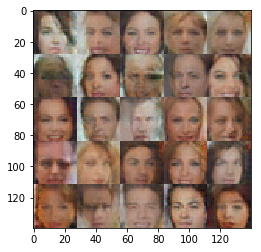

Epoch 2/2... Batch 1310... Discriminator Loss: 1.3129... Generator Loss: 0.8569
Epoch 2/2... Batch 1320... Discriminator Loss: 1.2031... Generator Loss: 0.8684
Epoch 2/2... Batch 1330... Discriminator Loss: 1.1881... Generator Loss: 0.8268
Epoch 2/2... Batch 1340... Discriminator Loss: 1.2059... Generator Loss: 1.1201
Epoch 2/2... Batch 1350... Discriminator Loss: 1.1500... Generator Loss: 0.8281
Epoch 2/2... Batch 1360... Discriminator Loss: 1.3267... Generator Loss: 0.9884
Epoch 2/2... Batch 1370... Discriminator Loss: 1.3146... Generator Loss: 1.2375
Epoch 2/2... Batch 1380... Discriminator Loss: 1.2760... Generator Loss: 0.8930
Epoch 2/2... Batch 1390... Discriminator Loss: 1.3185... Generator Loss: 0.9201
Epoch 2/2... Batch 1400... Discriminator Loss: 1.3479... Generator Loss: 0.9556


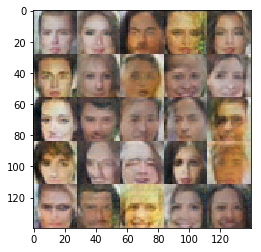

Epoch 2/2... Batch 1410... Discriminator Loss: 1.3442... Generator Loss: 1.0155
Epoch 2/2... Batch 1420... Discriminator Loss: 1.4421... Generator Loss: 1.1126
Epoch 2/2... Batch 1430... Discriminator Loss: 1.3498... Generator Loss: 0.6962
Epoch 2/2... Batch 1440... Discriminator Loss: 1.3179... Generator Loss: 1.3231
Epoch 2/2... Batch 1450... Discriminator Loss: 1.3431... Generator Loss: 1.0495
Epoch 2/2... Batch 1460... Discriminator Loss: 1.4576... Generator Loss: 0.7272
Epoch 2/2... Batch 1470... Discriminator Loss: 1.2719... Generator Loss: 0.8848
Epoch 2/2... Batch 1480... Discriminator Loss: 1.2815... Generator Loss: 0.8462
Epoch 2/2... Batch 1490... Discriminator Loss: 1.2656... Generator Loss: 0.6771
Epoch 2/2... Batch 1500... Discriminator Loss: 1.2650... Generator Loss: 0.6305


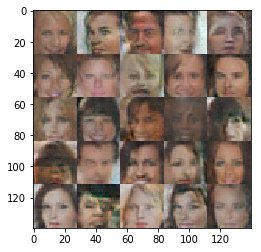

Epoch 2/2... Batch 1510... Discriminator Loss: 1.3555... Generator Loss: 1.0436
Epoch 2/2... Batch 1520... Discriminator Loss: 1.1180... Generator Loss: 1.2311
Epoch 2/2... Batch 1530... Discriminator Loss: 1.1720... Generator Loss: 1.2952
Epoch 2/2... Batch 1540... Discriminator Loss: 1.1669... Generator Loss: 0.8467
Epoch 2/2... Batch 1550... Discriminator Loss: 1.2100... Generator Loss: 0.6597
Epoch 2/2... Batch 1560... Discriminator Loss: 0.5804... Generator Loss: 2.1253
Epoch 2/2... Batch 1570... Discriminator Loss: 1.6923... Generator Loss: 0.4086
Epoch 2/2... Batch 1580... Discriminator Loss: 1.0155... Generator Loss: 1.2178


In [15]:
batch_size = 128
z_dim = 128
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.